# B02b: Phase Relationships (Quick Version)

**Duration**: ~25 minutes  
**Prerequisites**: B01, B02a

> 💡 **Quick Version**: This notebook imports pre-built functions from `src/phase.py` instead of defining them inline. For the full tutorial with step-by-step implementations, see [B02b_phase_relationships.ipynb](B02b_phase_relationships.ipynb).

## Learning Objectives

By the end of this notebook, you will be able to:
- Calculate phase difference between two signals
- Understand instantaneous vs average phase relationships
- Visualize phase coupling patterns
- Connect phase relationships to synchronization measures (PLV preview)

---

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Phase Difference](#section-2-phase-difference)
3. [Phase Locking Value Preview](#section-3-plv-preview)
4. [Application: Coupled Oscillators](#section-4-application)
5. [Exercises](#section-5-exercises)
6. [Summary](#summary)
7. [External Resources](#external-resources)
8. [Discussion Questions](#discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# Local imports
src_path = Path.cwd().parent.parent.parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from phase import (
    compute_phase_difference,
    circular_mean,
    resultant_vector_length,
    compute_plv_simple,
    plot_phase_polar_histogram
)
from hilbert import compute_instantaneous_phase
from filtering import bandpass_filter
from colors import COLORS

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/src


---

<a id="section-1-introduction"></a>
## 1. Introduction

In [B02a](B02a_circular_statistics.ipynb), we learned to analyze the phase of a **single signal**. Now we'll study **phase relationships between two signals**.

**Why phase relationships matter:**
- **Functional connectivity**: Brain regions working together show consistent phase relationships
- **Hyperscanning**: Phase synchrony between people indicates social coordination
- **Beyond correlation**: Phase locking can occur even when amplitudes vary independently

**Key concepts:**
- **Phase difference** Δφ(t) = φ₂(t) - φ₁(t)
- **Consistency**: If Δφ is constant, signals are locked
- **PLV**: Measures how consistent the phase difference is over time

---

<a id="section-2-phase-difference"></a>
## 2. Phase Difference Between Signals

The **phase difference** between two signals:

$$\Delta\phi(t) = \phi_2(t) - \phi_1(t)$$

Must be wrapped to [-π, π] to handle circularity.

In [2]:
# =============================================================================
# Section 2: Phase Difference
# =============================================================================

# Create signals
fs = 250  # Hz
duration = 2  # seconds
t = np.arange(0, duration, 1/fs)
freq = 10  # Hz

# Two signals with known phase relationships
signal1 = np.sin(2 * np.pi * freq * t)
signal2_inphase = np.sin(2 * np.pi * freq * t)  # 0° difference
signal2_quadrature = np.sin(2 * np.pi * freq * t + np.pi/2)  # 90° difference
signal2_antiphase = np.sin(2 * np.pi * freq * t + np.pi)  # 180° difference

# Extract phases
phase1 = compute_instantaneous_phase(signal1)
phase2_inphase = compute_instantaneous_phase(signal2_inphase)
phase2_quadrature = compute_instantaneous_phase(signal2_quadrature)
phase2_antiphase = compute_instantaneous_phase(signal2_antiphase)

# Compute phase differences
diff_inphase = compute_phase_difference(phase1, phase2_inphase)
diff_quadrature = compute_phase_difference(phase1, phase2_quadrature)
diff_antiphase = compute_phase_difference(phase1, phase2_antiphase)

# Print averages
print(f"In-phase (0°): mean Δφ = {np.degrees(circular_mean(diff_inphase)):.1f}°")
print(f"Quadrature (90°): mean Δφ = {np.degrees(circular_mean(diff_quadrature)):.1f}°")
print(f"Anti-phase (180°): mean Δφ = {np.degrees(circular_mean(diff_antiphase)):.1f}°")

In-phase (0°): mean Δφ = 0.0°
Quadrature (90°): mean Δφ = -90.0°
Anti-phase (180°): mean Δφ = 180.0°


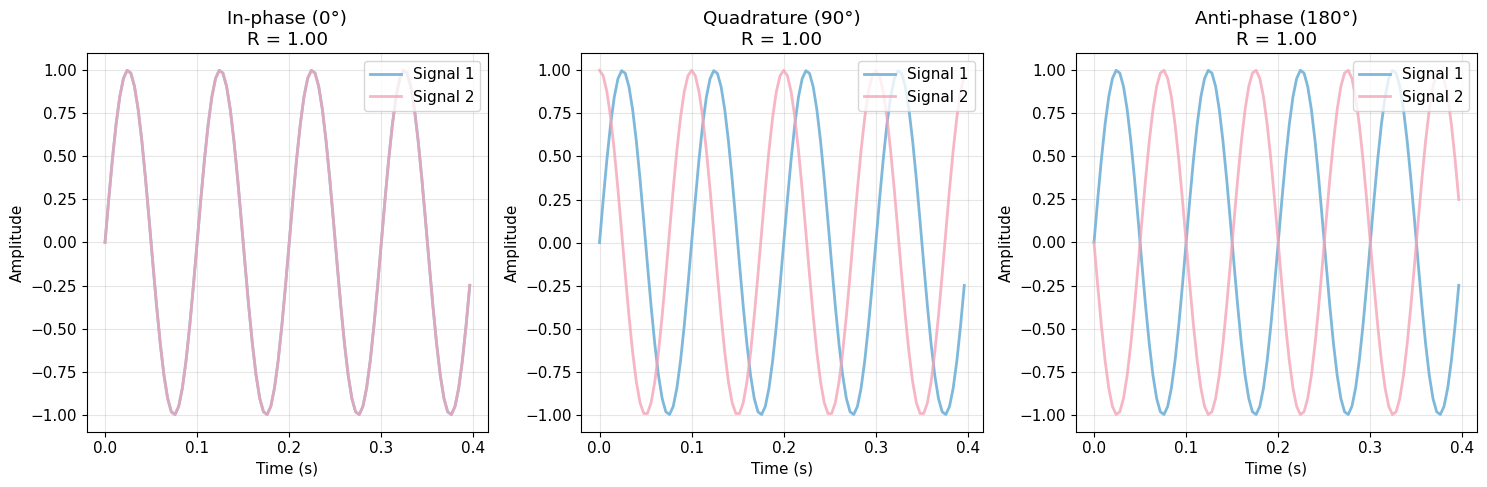

In [3]:
# Visualize phase differences
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

scenarios = [
    ("In-phase (0°)", signal2_inphase, diff_inphase),
    ("Quadrature (90°)", signal2_quadrature, diff_quadrature),
    ("Anti-phase (180°)", signal2_antiphase, diff_antiphase)
]

for ax, (name, sig2, diff) in zip(axes, scenarios):
    ax.plot(t[:100], signal1[:100], color=COLORS["signal_1"], label="Signal 1", linewidth=2)
    ax.plot(t[:100], sig2[:100], color=COLORS["signal_2"], label="Signal 2", linewidth=2, alpha=0.8)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{name}\nR = {resultant_vector_length(diff):.2f}")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

<a id="section-3-plv-preview"></a>
## 3. Phase Locking Value (PLV) Preview

The **PLV** quantifies phase relationship consistency:

$$PLV = \left| \frac{1}{N} \sum_{t=1}^{N} e^{i\Delta\phi(t)} \right| = R$$

- **PLV = 1**: Perfect phase locking (constant Δφ)
- **PLV = 0**: No consistent relationship (random Δφ)
- **Interpretation**: PLV is the resultant vector length of phase differences!

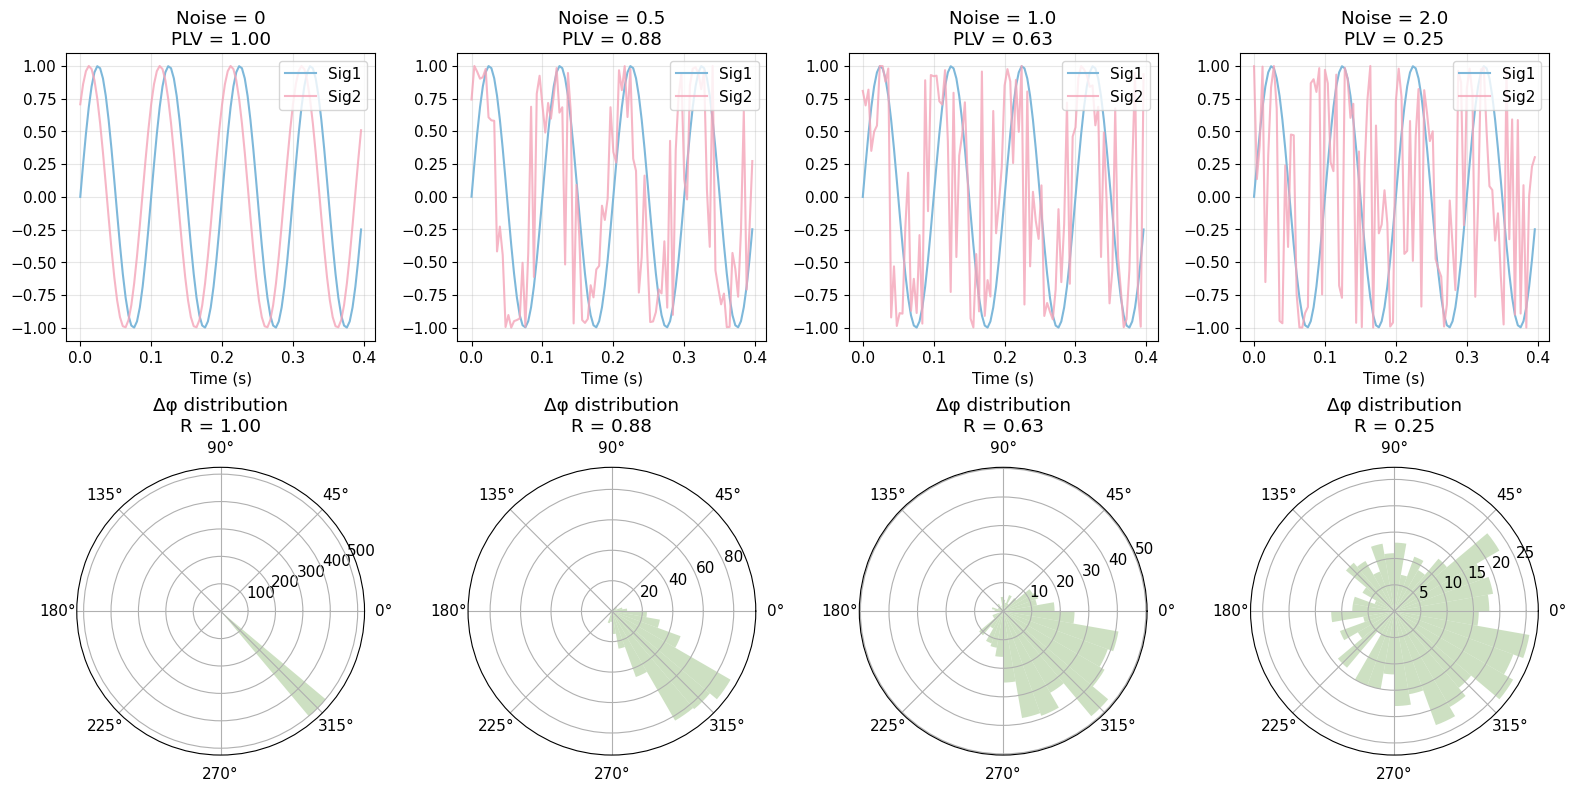


PLV decreases as phase noise increases:
  Noise = 0: PLV = 1.000
  Noise = 0.5: PLV = 0.879
  Noise = 1.0: PLV = 0.631
  Noise = 2.0: PLV = 0.250


In [4]:
# =============================================================================
# Section 3: PLV with varying noise
# =============================================================================

# Generate signals with different coupling strengths
phase_shift = np.pi / 4  # Base phase difference
noise_levels = [0, 0.5, 1.0, 2.0]
plv_values = []

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, noise in enumerate(noise_levels):
    # Create signals with phase noise
    signal1 = np.sin(2 * np.pi * freq * t)
    noisy_phase = phase_shift + noise * np.random.randn(len(t))
    signal2 = np.sin(2 * np.pi * freq * t + noisy_phase)
    
    # Extract phases and compute difference
    phase1 = compute_instantaneous_phase(signal1)
    phase2 = compute_instantaneous_phase(signal2)
    diff = compute_phase_difference(phase1, phase2)
    
    # Compute PLV
    plv = compute_plv_simple(phase1, phase2)
    plv_values.append(plv)
    
    # Time series
    axes[0, idx].plot(t[:100], signal1[:100], color=COLORS["signal_1"], label="Sig1")
    axes[0, idx].plot(t[:100], signal2[:100], color=COLORS["signal_2"], label="Sig2", alpha=0.8)
    axes[0, idx].set_title(f"Noise = {noise}\nPLV = {plv:.2f}")
    axes[0, idx].set_xlabel("Time (s)")
    axes[0, idx].legend(loc="upper right")
    axes[0, idx].grid(True, alpha=0.3)
    
    # Phase difference histogram on polar plot
    ax_polar = fig.add_subplot(2, 4, idx + 5, projection="polar")
    bins = np.linspace(-np.pi, np.pi, 37)
    counts, edges = np.histogram(diff, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    width = edges[1] - edges[0]
    ax_polar.bar(centers, counts, width=width, color=COLORS["signal_3"], alpha=0.7)
    ax_polar.set_title(f"Δφ distribution\nR = {resultant_vector_length(diff):.2f}")
    axes[1, idx].axis("off")

plt.tight_layout()
plt.show()

print("\nPLV decreases as phase noise increases:")
for noise, plv in zip(noise_levels, plv_values):
    print(f"  Noise = {noise}: PLV = {plv:.3f}")

---

<a id="section-4-application"></a>
## 4. Application: Two Coupled Oscillators

Simulating a hyperscanning-like scenario with two "brains" that can be:
- **Uncoupled**: Independent oscillators
- **Weakly coupled**: Some phase attraction
- **Strongly coupled**: Phase-locked

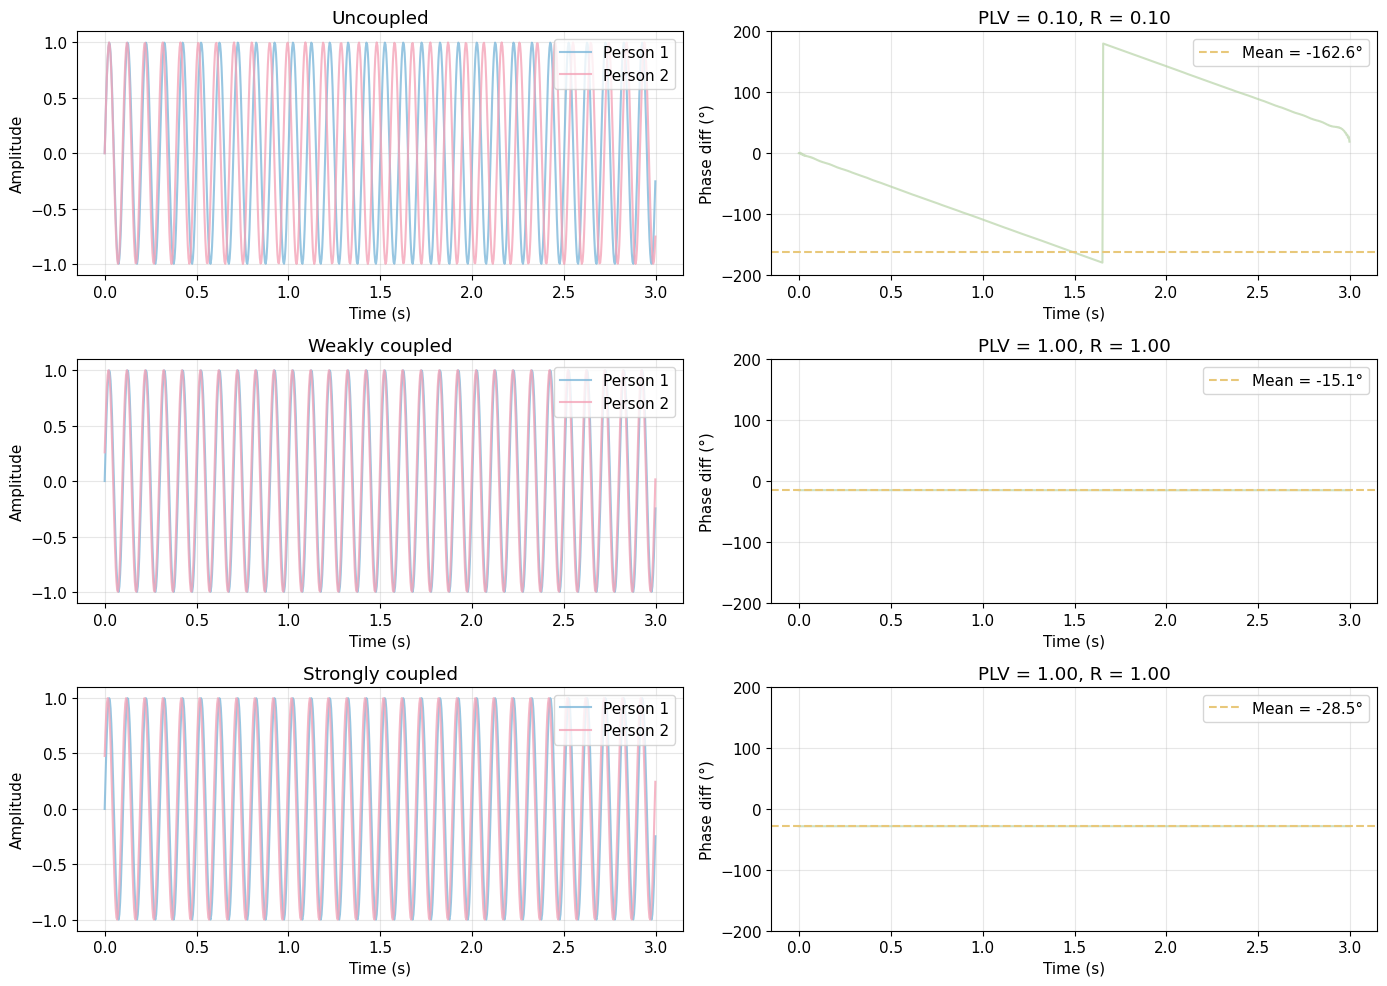

In [5]:
# =============================================================================
# Section 4: Coupled Oscillators Simulation
# =============================================================================

# Simulate 3 conditions
np.random.seed(42)
duration = 3
t = np.arange(0, duration, 1/fs)

# Base frequencies (slightly different for uncoupled case)
freq1 = 10.0
freq2_uncoupled = 10.3  # Slightly different

conditions = {
    "Uncoupled": (0.0, freq2_uncoupled),
    "Weakly coupled": (0.5, freq1),
    "Strongly coupled": (0.95, freq1)
}

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for i, (condition_name, (coupling, f2)) in enumerate(conditions.items()):
    # Person 1: simple oscillator
    phase_drift_1 = 2 * np.pi * freq1 * t + np.cumsum(0.1 * np.random.randn(len(t))) / fs
    
    # Person 2: influenced by Person 1 based on coupling
    independent_drift = 2 * np.pi * f2 * t + np.cumsum(0.1 * np.random.randn(len(t))) / fs
    coupled_component = phase_drift_1 + np.pi/6  # 30° lag
    phase_drift_2 = coupling * coupled_component + (1 - coupling) * independent_drift
    
    # Create signals
    signal_p1 = np.sin(phase_drift_1)
    signal_p2 = np.sin(phase_drift_2)
    
    # Extract phases
    phase_p1 = compute_instantaneous_phase(signal_p1)
    phase_p2 = compute_instantaneous_phase(signal_p2)
    
    # Compute phase difference and PLV
    diff = compute_phase_difference(phase_p1, phase_p2)
    plv_val = compute_plv_simple(phase_p1, phase_p2)
    avg_diff = circular_mean(diff)
    R = resultant_vector_length(diff)
    
    # Time series
    axes[i, 0].plot(t, signal_p1, color=COLORS["signal_1"], label="Person 1", alpha=0.8)
    axes[i, 0].plot(t, signal_p2, color=COLORS["signal_2"], label="Person 2", alpha=0.8)
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].set_title(f"{condition_name}")
    axes[i, 0].legend(loc="upper right")
    axes[i, 0].grid(True, alpha=0.3)
    
    # Phase difference over time
    axes[i, 1].plot(t, np.degrees(diff), color=COLORS["signal_3"], alpha=0.7)
    axes[i, 1].axhline(np.degrees(avg_diff), color=COLORS["signal_4"], linestyle="--", 
                       label=f"Mean = {np.degrees(avg_diff):.1f}°")
    axes[i, 1].set_xlabel("Time (s)")
    axes[i, 1].set_ylabel("Phase diff (°)")
    axes[i, 1].set_title(f"PLV = {plv_val:.2f}, R = {R:.2f}")
    axes[i, 1].set_ylim(-200, 200)
    axes[i, 1].legend(loc="upper right")
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

<a id="section-5-exercises"></a>
## 5. Exercises

### 🎯 Exercise 1: Phase Lag Detection

**Task:** Create two 10 Hz signals where Signal 2 lags Signal 1 by 45°. Verify the lag using phase difference computation.

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Create signals with 45° lag
lag_deg = 45
lag_rad = np.radians(lag_deg)

t = np.arange(0, 2, 1/250)
sig1 = np.sin(2 * np.pi * 10 * t)
sig2 = np.sin(2 * np.pi * 10 * t - lag_rad)  # Negative = lag

# Extract phases and compute difference
phase1 = compute_instantaneous_phase(sig1)
phase2 = compute_instantaneous_phase(sig2)
diff = compute_phase_difference(phase1, phase2)

print(f"Expected lag: -{lag_deg}°")
print(f"Measured: {np.degrees(circular_mean(diff)):.1f}°")
print(f"PLV: {compute_plv_simple(phase1, phase2):.3f}")
```

</details>

### 🎯 Exercise 2: Time-Varying PLV

**Task:** Compute PLV in sliding windows (1 second, 50% overlap) for the strongly coupled oscillators from Section 4.

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Sliding window PLV
window_size = int(1.0 * fs)  # 1 second
step = window_size // 2  # 50% overlap

# Use strongly coupled signals from Section 4
coupling = 0.95
phase_drift_1 = 2 * np.pi * 10 * t + np.cumsum(0.1 * np.random.randn(len(t))) / fs
phase_drift_2 = coupling * (phase_drift_1 + np.pi/6) + (1 - coupling) * (2 * np.pi * 10 * t)

signal_p1 = np.sin(phase_drift_1)
signal_p2 = np.sin(phase_drift_2)

phase_p1 = compute_instantaneous_phase(signal_p1)
phase_p2 = compute_instantaneous_phase(signal_p2)

# Compute windowed PLV
plv_times = []
plv_vals = []
for start in range(0, len(t) - window_size, step):
    end = start + window_size
    plv_win = compute_plv_simple(phase_p1[start:end], phase_p2[start:end])
    plv_times.append(t[start + window_size // 2])
    plv_vals.append(plv_win)

plt.figure(figsize=(10, 4))
plt.plot(plv_times, plv_vals, 'o-', color=COLORS["signal_1"])
plt.xlabel("Time (s)")
plt.ylabel("PLV")
plt.title("Time-varying PLV (1s windows, 50% overlap)")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()
```

</details>

---

<a id="summary"></a>
## 6. Summary

### Key Concepts

| Concept | Formula | Interpretation |
|---------|---------|----------------|
| **Phase difference** | Δφ(t) = φ₂(t) - φ₁(t) | Instantaneous relationship |
| **Average phase diff** | $\bar{\Delta\phi}$ = circular_mean(Δφ) | Typical lag/lead |
| **PLV** | R of phase differences | Consistency of relationship |

### Complete Workflow

```python
# 1. Extract phases
phase1 = compute_instantaneous_phase(signal1)
phase2 = compute_instantaneous_phase(signal2)

# 2. Compute phase difference
diff = compute_phase_difference(phase1, phase2)

# 3. Analyze relationship
avg_diff = circular_mean(diff)  # Average lag
plv = compute_plv_simple(phase1, phase2)  # Consistency
```

### Key Insights

1. **PLV = R**: Phase Locking Value is the resultant vector length of phase differences
2. **High PLV ≠ in-phase**: Signals can be anti-phase (180°) and still have PLV = 1
3. **Filter first**: Always extract phase from narrowband-filtered signals

---

<a id="external-resources"></a>
## 7. External Resources

### 📚 Scientific References

- **Lachaux et al. (1999)** - *Measuring phase synchrony in brain signals* - Original PLV paper
- **Pikovsky et al. (2001)** - *Synchronization: A Universal Concept in Nonlinear Sciences*

### 🎧 NotebookLM Resources

- [📺 Video Overview](https://notebooklm.google.com/notebook/d4d31cd1-619f-4df5-825c-2a038cabe293?artifactId=c94ced23-51f9-4815-aedb-6846967a4fe8) - Video overview of phase relationships concepts
- [📝 Quiz](https://notebooklm.google.com/notebook/d4d31cd1-619f-4df5-825c-2a038cabe293?artifactId=8cdfcc8f-9aec-4ac6-a2c2-a92de5d69c08) - Test your understanding of phase synchronization
- [🗂️ Flashcards](https://notebooklm.google.com/notebook/d4d31cd1-619f-4df5-825c-2a038cabe293?artifactId=e2bafda8-4b67-475a-949f-e54d43c4ad1f) - Review key concepts

---

<a id="discussion-questions"></a>
## 8. Discussion Questions

1. **In-phase vs Anti-phase**: Two brain regions show PLV = 0.9 with average phase difference of 180°. Are they coupled? What might this mean functionally?

2. **Frequency matters**: Why must you filter to a specific band before computing PLV? What would happen with broadband signals?

3. **Statistical significance**: In a hyperscanning experiment with PLV = 0.6, how would you determine if this is significant?

---

**Next Steps:**
- [B03: Amplitude Envelope](B03_amplitude_envelope.ipynb)
- [G01: Phase Locking Value](../../02_connectivity_metrics/G_phase_based/G01_phase_locking_value.ipynb) - Full PLV implementation